In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import json
import os

In [134]:
def encontrar_id(id_line):
    anterior = False
    img_id = ""
    for i in id_line:
        if i.isnumeric():
            img_id += i
            anterior = True
        elif anterior:
            break
    return img_id

In [135]:
# Transforming the lines into a matrix 4214 vectors X 4096 features
def read_dataset(route):
    dataset = open(route,"r")
    matrix = []
    img_ids = []
    for data_line in dataset.readlines():
        data_line = data_line.strip()
        id_line = data_line
        # Obtengo vectores
        data_line = data_line[data_line.find("["):]
        matrix.append(json.loads(data_line))
        # Obtengo id
        img_id = encontrar_id(id_line)
        img_ids.append(img_id)
        
    return (img_ids, np.asarray(matrix))

In [136]:
def pca_reduction(dataset, n_components):
    pca = PCA(n_components=n_components)
    rpm = pca.fit_transform(dataset) #reduced pca matrix
    return rpm

In [137]:
def kmeans(dataset, clusters):
    my_kmeans = KMeans(n_clusters=clusters)
    my_kmeans.fit(dataset)
    return my_kmeans

In [138]:
def ms(dataset):
    my_ms = MeanShift()
    my_ms.fit(dataset)
    return my_ms

In [139]:
def db(dataset, eps, min_samples):
    my_db = DBSCAN(eps=eps, min_samples=min_samples)
    my_db.fit(dataset)
    return my_db

In [140]:
def TS(dataset, n_components, perplexity):
    my_ts = TSNE(n_components=n_components, perplexity=perplexity)
    reduction = my_ts.fit_transform(dataset)
    return reduction

In [141]:
def data_to_csv(file_name, ids, labels, positions):
    data = []
    for i in range(0, len(ids)):
        img_id = ids[i]
        x = positions[i][0]
        y = positions[i][1]
        label = labels[i]
        file_route = "img/" + img_id + ".jpg"
        thumbnail_route = "img/thumbs/" + img_id + ".jpg"
        data.append([img_id, x, y, label, file_route, thumbnail_route])
    
    df = pd.DataFrame(data = data, columns=['id', 'x', 'y', 'class', 'file', 'thumbnail'])
    df.to_csv(file_name, index=False, header=True)

In [142]:
def normalize(lista):
    minimoX = min(list(zip(*lista))[0])
    maximoX = max(list(zip(*lista))[0])
    minimoY = min(list(zip(*lista))[1])
    maximoY = max(list(zip(*lista))[1])
    return list(zip(list(map(lambda x: (x[0] - minimoX)/(maximoX - minimoX), lista)) ,list(map(lambda x: (x[1] - minimoY)/(maximoY - minimoY), lista))))

# Reduccion de diemensionalidad con PCA

In [143]:
# PCA
dataset = read_dataset("byArtworkID/dataset.txt")[1]
rpm = pca_reduction(dataset, 50) # rpm -> reduced pca matrix

# Ejecucion de algoritmos de clustering

   ## KMeans

In [144]:
# KMeans
my_kmeans10 = kmeans(rpm, 10)
km_centers10 = my_kmeans10.cluster_centers_
km_labels10 = my_kmeans10.labels_

my_kmeans20 = kmeans(rpm, 20)
km_centers20 = my_kmeans20.cluster_centers_
km_labels20 = my_kmeans20.labels_

my_kmeans30 = kmeans(rpm, 30)
km_centers30 = my_kmeans30.cluster_centers_
km_labels30 = my_kmeans30.labels_

## MeanShift

In [145]:
# MeanShift
my_ms = ms(rpm)
ms_centers = my_ms.cluster_centers_
ms_labels = my_ms.labels_

## DBScan

Para calcular el numero de clusters usamos el codigo que se muestra en este [ejemplo](http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)

In [146]:
# DBSCAN
my_db_default = db(rpm, 0.5, 5)
db_components_default = my_db_default.components_
db_labels_default = my_db_default.labels_
db_clusters_default = len(set(db_labels_default)) - (1 if -1 in db_labels_default else 0)

my_db_1 = db(rpm, 0.5, 2)
db_components_1 = my_db_1.components_
db_labels_1 = my_db_1.labels_
db_clusters_1 = len(set(db_labels_1)) - (1 if -1 in db_labels_1 else 0)

my_db_2 = db(rpm, 150, 4)
db_components_2 = my_db_2.components_
db_labels_2 = my_db_2.labels_
db_clusters_2 = len(set(db_labels_2)) - (1 if -1 in db_labels_2 else 0)

# Reduccion de dimensionalidad con T-SNE

In [147]:
# TSNE reduction
ts_reduced = TS(rpm, 2, 50)

# Generar archivos csv

In [148]:
# Generando archivos csv
ids = read_dataset("byArtworkID/dataset.txt")[0]
positions = normalize(ts_reduced)
if not os.path.exists("datasets"):
    os.makedirs("datasets")

# Datos KMeans
data_to_csv("datasets/KM_data_10.csv", ids, km_labels10, positions)
data_to_csv("datasets/KM_data_20.csv", ids, km_labels20, positions)
data_to_csv("datasets/KS_data_30.csv", ids, km_labels30, positions)

# Datos MeanShift
data_to_csv("datasets/MS_data.csv", ids, ms_labels, positions)

# Datos DBSCAN
data_to_csv("datasets/DB_data_default.csv", ids, db_labels_default, positions)
data_to_csv("datasets/DB_data_1.csv", ids, db_labels_1, positions)
data_to_csv("datasets/DB_data_2.csv", ids, db_labels_2, positions)

# Graficos de labels para cada algoritmo con sus respectivos argumentos
## KMeans
### n_clusters = 10

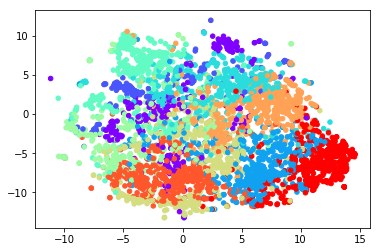

In [149]:
plt.scatter(ts_reduced[:, 0], ts_reduced[:, 1], c=km_labels10, s=20, cmap='rainbow');

### n_clusters = 20

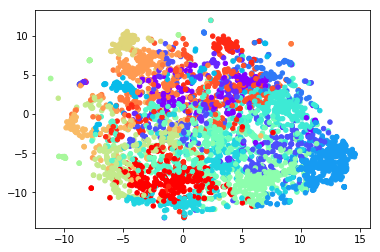

In [150]:
plt.scatter(ts_reduced[:, 0], ts_reduced[:, 1], c=km_labels20, s=20, cmap='rainbow');

### n_clusters = 30

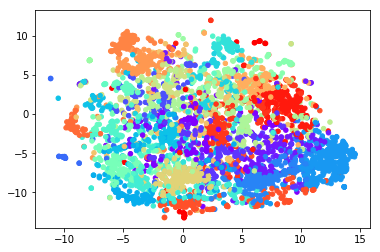

In [151]:
plt.scatter(ts_reduced[:, 0], ts_reduced[:, 1], c=km_labels30, s=20, cmap='rainbow');

## MeanShift

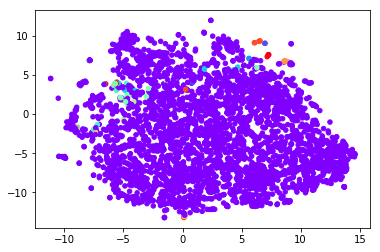

In [155]:
plt.scatter(ts_reduced[:, 0], ts_reduced[:, 1], c=ms_labels, s=20, cmap='rainbow');

## DBScan
### Default ( eps=0.5, min_samples=5 )

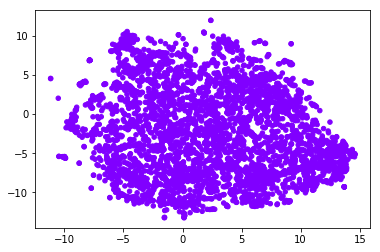

In [152]:
plt.scatter(ts_reduced[:, 0], ts_reduced[:, 1], c=db_labels_default, s=20, cmap='rainbow');

### eps=0.5, min_samples=2

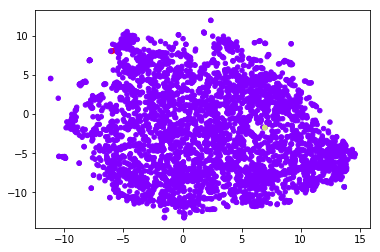

In [153]:
plt.scatter(ts_reduced[:, 0], ts_reduced[:, 1], c=db_labels_1, s=20, cmap='rainbow');

### eps=150, min_samples=4

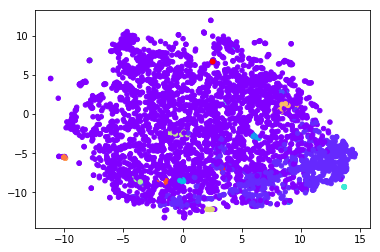

In [154]:
plt.scatter(ts_reduced[:, 0], ts_reduced[:, 1], c=db_labels_2, s=20, cmap='rainbow');

# Calculo de Silhouette Score

In [156]:
print(silhouette_score(rpm, km_labels10))
print(silhouette_score(rpm, km_labels20))
print(silhouette_score(rpm, km_labels30))

print(silhouette_score(rpm, ms_labels))

#print(silhouette_score(rpm, db_labels_default)) # 0 Clusters con default
print(silhouette_score(rpm, db_labels_1))
print(silhouette_score(rpm, db_labels_2))

0.0540114168266
0.0540319770445
0.0550646632473
0.215734653618
-0.100149531082
-0.194101650753
